In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score, GridSearchCV

from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier


In [2]:
# ignore all warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Loading Data
gender = pd.read_csv('/kaggle/input/titanic/gender_submission.csv')
test = pd.read_csv('/kaggle/input/titanic/test.csv')
train = pd.read_csv('/kaggle/input/titanic/train.csv')

In [4]:
# Merge the DataFrames
df = pd.concat([train,test,gender],ignore_index=True)

# Save the merged dataframe
# df.to_save('merged_data.csv', index=False)

In [5]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3.0,"Braund, Mr. Owen Harris",male,22.0,1.0,0.0,A/5 21171,7.2500,NaN,S
1,2,1.0,1.0,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1.0,0.0,PC 17599,71.2833,C85,C
2,3,1.0,3.0,"Heikkinen, Miss. Laina",female,26.0,0.0,0.0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1.0,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1.0,0.0,113803,53.1000,C123,S
4,5,0.0,3.0,"Allen, Mr. William Henry",male,35.0,0.0,0.0,373450,8.0500,NaN,S


In [6]:
# col maximum
pd.set_option('display.max_columns',None)
# row maximum
pd.set_option('display.max_rows',None)

In [7]:
# check missing value
df.isnull().sum()

PassengerId       0
Survived        418
Pclass          418
Name            418
Sex             418
Age             681
SibSp           418
Parch           418
Ticket          418
Fare            419
Cabin          1432
Embarked        420
dtype: int64

In [8]:
# percentage
missing_percentage = df.isnull().mean()*100
print(missing_percentage)

PassengerId     0.000000
Survived       24.203822
Pclass         24.203822
Name           24.203822
Sex            24.203822
Age            39.432542
SibSp          24.203822
Parch          24.203822
Ticket         24.203822
Fare           24.261726
Cabin          82.918356
Embarked       24.319629
dtype: float64


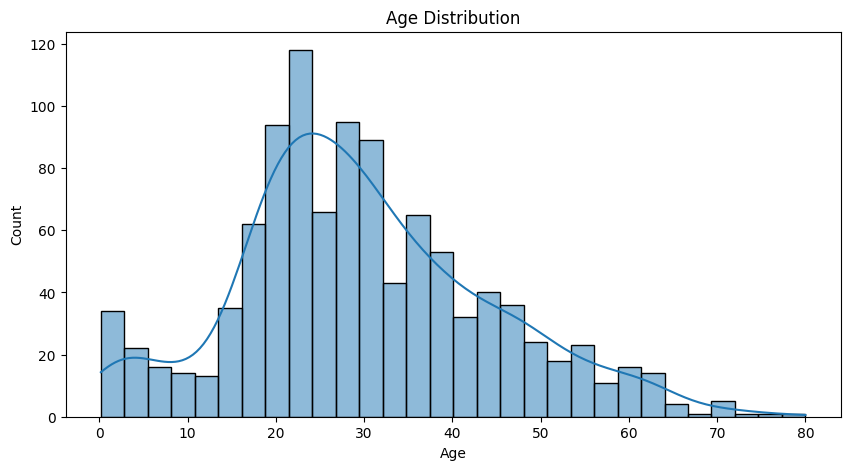

In [9]:
# Age distributution
plt.figure(figsize=(10,5))
sns.histplot(df['Age'],bins=30,kde=True)
plt.title('Age Distribution')
plt.show()

In [10]:
# Impute missing age
df['Age'].fillna(df['Age'].mode()[0], inplace=True)

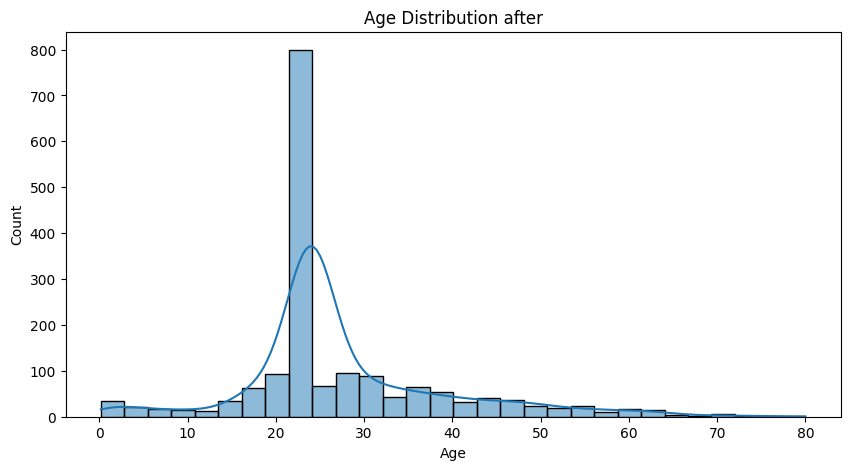

In [11]:
# After Age Distribution
plt.figure(figsize=(10,5))
sns.histplot(df['Age'],bins=30,kde=True)
plt.title('Age Distribution after')
plt.show()

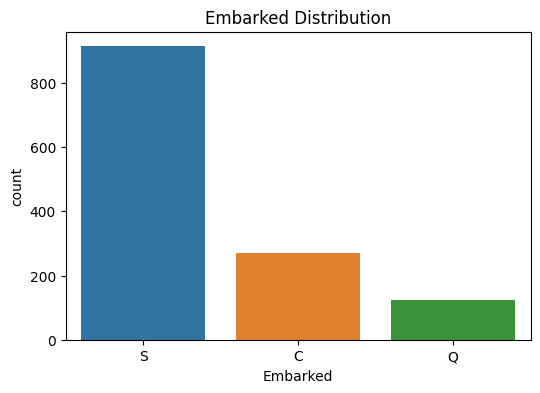

In [12]:
# Embarked Distribution
plt.figure(figsize=(6,4))
sns.countplot(x='Embarked',data=df)
plt.title('Embarked Distribution')
plt.show()

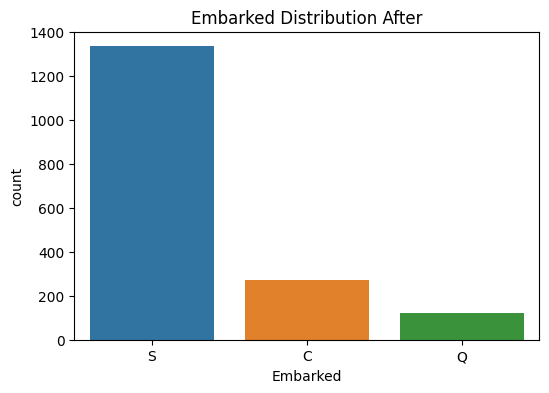

In [13]:
# Embarked Distribution after imputation
df['Embarked'].fillna(df['Embarked'].mode()[0],inplace=True)

plt.figure(figsize=(6,4))
sns.countplot(x='Embarked',data=df)
plt.title('Embarked Distribution After')
plt.show()

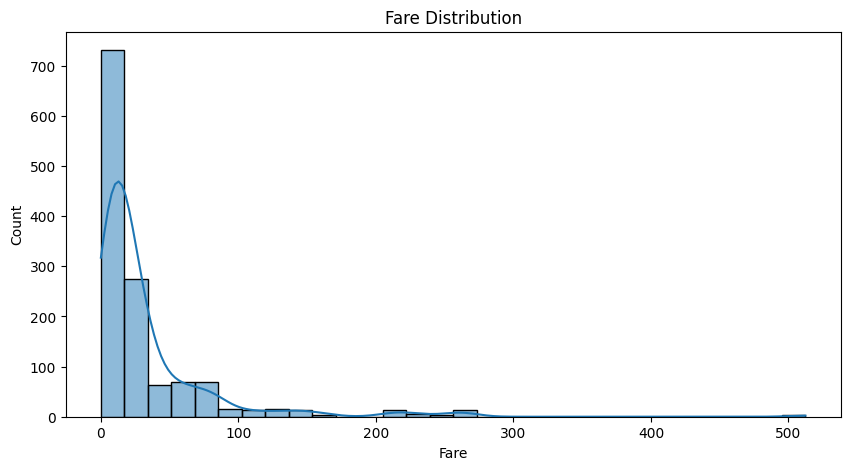

In [14]:
# Fare Distirbution
plt.figure(figsize=(10,5))
sns.histplot(df['Fare'],bins=30,kde=True)
plt.title('Fare Distribution')
plt.show()

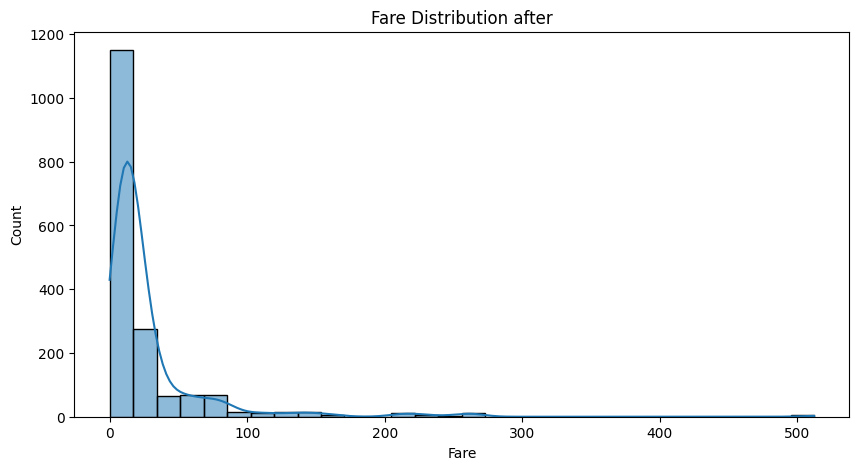

In [15]:
# Fare Distribution after 
df['Fare'].fillna(df['Fare'].median(), inplace=True)
plt.figure(figsize=(10,5))
sns.histplot(df['Fare'],bins=30,kde=True)
plt.title('Fare Distribution after')
plt.show()

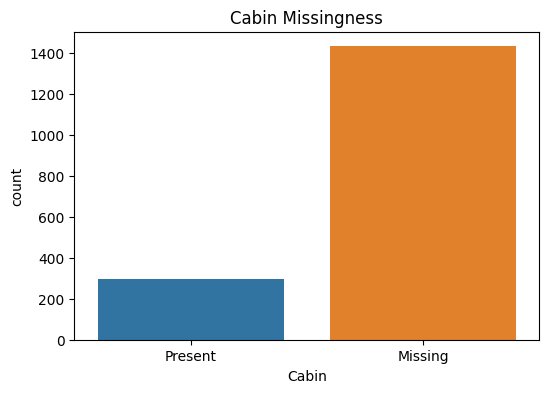

In [16]:
# Cabin Missingness
plt.figure(figsize=(6, 4))
sns.countplot(x=df['Cabin'].isnull())
plt.title('Cabin Missingness')
plt.xticks([0, 1], ['Present', 'Missing'])
plt.show()

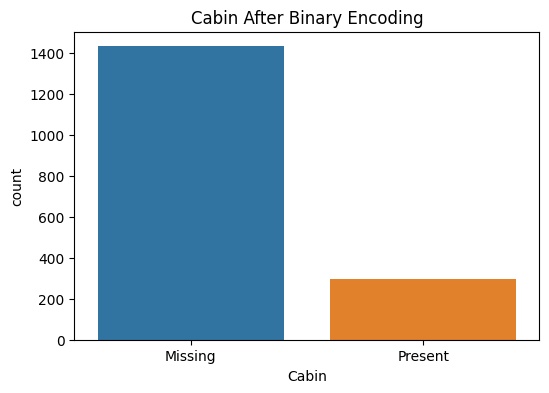

In [17]:
# Cabin Missingness after
df['Cabin'] = df['Cabin'].notnull().astype(int)
plt.figure(figsize=(6, 4))

sns.countplot(x=df['Cabin'])
plt.title('Cabin After Binary Encoding')
plt.xticks([0, 1], ['Missing', 'Present'])
plt.show()

In [18]:
# Categorical col
for col in ['Pclass', 'SibSp', 'Parch', 'Ticket', 'Survived']:
    df[col].fillna(df[col].mode()[0], inplace=True)

df = df[df['Name'].notnull()]
df['Sex'].fillna(df['Sex'].mode()[0], inplace=True)
print(df.isnull().sum())

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64


In [19]:
# Feature Engineering
df['Title'] = df['Name'].str.extract(' ([A-Za-z]+)\.',expand=False)

# Impute missing Embarked
df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)

# Encoding Categorical
df['Sex'] = LabelEncoder().fit_transform(df['Sex'])
df = pd.get_dummies(df, columns=['Embarked', 'Title'])

# Define features
X = df.drop(columns=['Survived','Name','Ticket','PassengerId'])
y = df['Survived']


# Training and test sets
X_train,X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

# Train Random Classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.683206106870229
              precision    recall  f1-score   support

         0.0       0.78      0.79      0.78       189
         1.0       0.43      0.41      0.42        73

    accuracy                           0.68       262
   macro avg       0.60      0.60      0.60       262
weighted avg       0.68      0.68      0.68       262



In [20]:
# SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
model.fit(X_resampled, y_resampled)
y_pred_resampled = model.predict(X_test)
print("SMOTE accuracy:", accuracy_score(y_test,y_pred_resampled))
print(classification_report(y_test,y_pred_resampled))

SMOTE accuracy: 0.683206106870229
              precision    recall  f1-score   support

         0.0       0.80      0.75      0.77       189
         1.0       0.44      0.51      0.47        73

    accuracy                           0.68       262
   macro avg       0.62      0.63      0.62       262
weighted avg       0.70      0.68      0.69       262



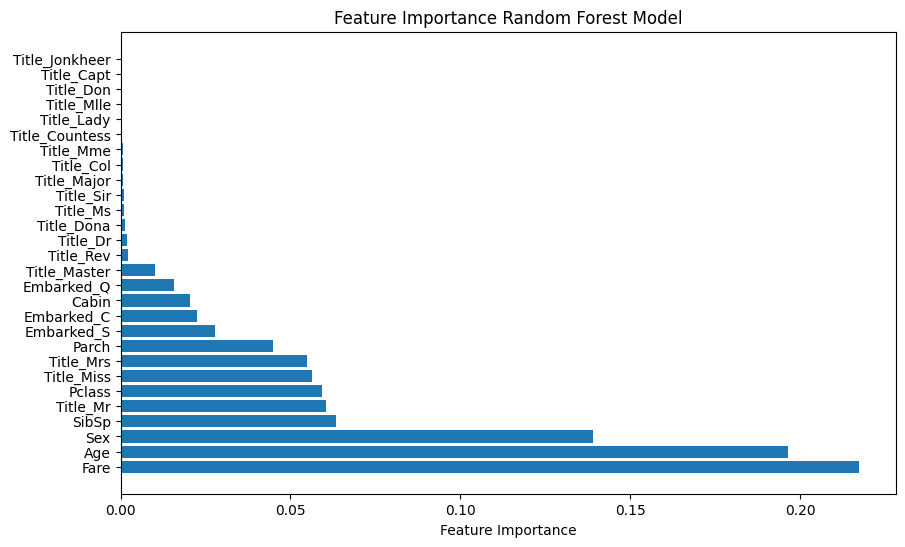

In [21]:
# Feature
importance = model.feature_importances_
feature_names = X.columns
importance_df = pd.DataFrame({'Feature': feature_names,'Importance':importance})
importance_df = importance_df.sort_values(by='Importance',ascending=False)
plt.figure(figsize=(10,6))
plt.barh(importance_df['Feature'],importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.title('Feature Importance Random Forest Model')
plt.show()

In [22]:
# DataFrame Load
print("Current columns in df:", df.columns)
df['Family_Size'] = df['SibSp'] + df['Parch'] + 1
df['Age_Binned'] = pd.cut(df['Age'], bins=[0, 12, 18, 30, 50, 80], labels=['Child', 'Teen', 'Young Adult', 'Adult', 'Elderly'])
df = pd.get_dummies(df, columns=['Sex', 'Age_Binned'], drop_first=True)
X = df.drop(columns=['Survived', 'Name', 'Ticket', 'PassengerId', 'Cabin'])
y = df['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Current columns in df: Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked_C', 'Embarked_Q',
       'Embarked_S', 'Title_Capt', 'Title_Col', 'Title_Countess', 'Title_Don',
       'Title_Dona', 'Title_Dr', 'Title_Jonkheer', 'Title_Lady', 'Title_Major',
       'Title_Master', 'Title_Miss', 'Title_Mlle', 'Title_Mme', 'Title_Mr',
       'Title_Mrs', 'Title_Ms', 'Title_Rev', 'Title_Sir'],
      dtype='object')
Accuracy: 0.7251908396946565
              precision    recall  f1-score   support

         0.0       0.81      0.80      0.81       189
         1.0       0.51      0.52      0.51        73

    accuracy                           0.73       262
   macro avg       0.66      0.66      0.66       262
weighted avg       0.73      0.73      0.73       262



In [23]:
# Train a new model
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]))
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Accuracy: ", accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))

Accuracy:  0.6946564885496184
              precision    recall  f1-score   support

         0.0       0.81      0.75      0.78       189
         1.0       0.46      0.55      0.50        73

    accuracy                           0.69       262
   macro avg       0.64      0.65      0.64       262
weighted avg       0.71      0.69      0.70       262



In [24]:
# Accuracy
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Train the model with the resampled data

model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

model.fit(X_train_resampled, y_train_resampled)

# Predictions and evaluation

y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))

print(classification_report(y_test, y_pred))

Accuracy: 0.7290076335877863
              precision    recall  f1-score   support

         0.0       0.81      0.81      0.81       189
         1.0       0.51      0.52      0.52        73

    accuracy                           0.73       262
   macro avg       0.66      0.67      0.66       262
weighted avg       0.73      0.73      0.73       262



In [25]:
# GridSearch
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
param_grid = {
    'max_depth' : [3,5,7,10],
    'learning_rate' : [0.01,0.1,0.2],
    'n_estimators' : [100,200,300],
    'subsample' : [0.8, 1.0],
}
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy')



# Fit the model

grid_search.fit(X_train, y_train)



# Get the best parameters and model

best_model = grid_search.best_estimator_

print("Best Parameters:", grid_search.best_params_)



# Predictions with the best model

y_pred = best_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))

print(classification_report(y_test, y_pred))

Best Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1.0}
Accuracy: 0.7977099236641222
              precision    recall  f1-score   support

         0.0       0.81      0.93      0.87       189
         1.0       0.72      0.45      0.55        73

    accuracy                           0.80       262
   macro avg       0.77      0.69      0.71       262
weighted avg       0.79      0.80      0.78       262



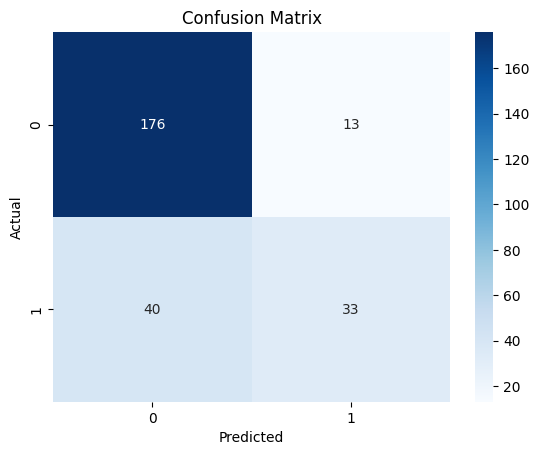

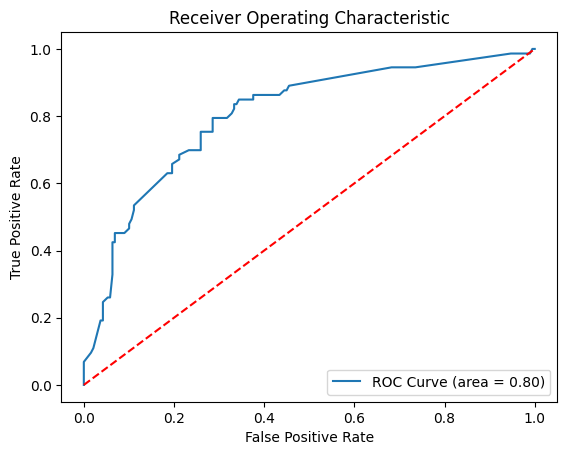

In [26]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot = True, fmt = 'd', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

y_pred_proba = best_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)

plt.plot(fpr,tpr,label='ROC Curve (area = {:.2f})'.format(roc_auc))
plt.plot([0,1], [0,1], 'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()